In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_moons

import bayesnet as bn


np.random.seed(1234)

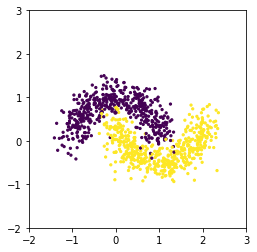

In [2]:
x_train, y_train = make_moons(n_samples=1000, noise=0.2)
y_train = y_train[:, None]
plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=5)
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [3]:
class NeuralNetwork(bn.Network):
    
    def __init__(self, n_input, n_hidden, n_output=1):
        super().__init__(
            w1=np.random.randn(n_input, n_hidden),
            b1=np.zeros(n_hidden),
            w2=np.random.randn(n_hidden, n_hidden),
            b2=np.zeros(n_hidden),
            w3=np.random.randn(n_hidden, n_output),
            b3=np.zeros(n_output)
        )

    def __call__(self, x, y=None):
        h = bn.tanh(x @ self.w1 + self.b1)
        h = bn.tanh(h @ self.w2 + self.b2)
        self.y = bn.random.Bernoulli(logit=h @ self.w3 + self.b3, data=y)
        return self.y.mu.value

In [4]:
model = NeuralNetwork(2, 5, 1)
optimizer = bn.optimizer.Adam(model, 1e-3)
for i in range(50000):
    model.cleargrad()
    model(x_train, y_train)
    loss = -model.elbo()
    loss.backward()
    optimizer.update()

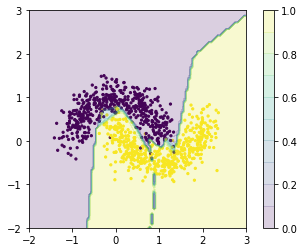

In [5]:
x_grid = np.mgrid[-2:3:100j, -2:3:100j]
x1, x2 = x_grid[0], x_grid[1]
x_grid = x_grid.reshape(2, -1).T

y_grid = model(x_grid).reshape(100, 100)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=5)
plt.contourf(x1, x2, y_grid, np.linspace(0, 1, 11), alpha=0.2)
plt.colorbar()
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [6]:
class BayesianNetwork(bn.Network):
    
    def __init__(self, n_input, n_hidden, n_output=1):
        super().__init__(
            w1_mu=np.zeros((n_input, n_hidden)),
            w1_s=np.zeros((n_input, n_hidden)),
            b1_mu=np.zeros(n_hidden),
            b1_s=np.zeros(n_hidden),
            w2_mu=np.zeros((n_hidden, n_hidden)),
            w2_s=np.zeros((n_hidden, n_hidden)),
            b2_mu=np.zeros(n_hidden),
            b2_s=np.zeros(n_hidden),
            w3_mu=np.zeros((n_hidden, n_output)),
            w3_s=np.zeros((n_hidden, n_output)),
            b3_mu=np.zeros(n_output),
            b3_s=np.zeros(n_output)
        )

    def __call__(self, x, y=None):
        self.w1 = bn.random.Gaussian(
            self.w1_mu, bn.softplus(self.w1_s),
            prior=bn.random.Gaussian(np.zeros(self.w1_mu.shape), np.ones(self.w1_mu.shape))
        )
        self.b1 = bn.random.Gaussian(
            self.b1_mu, bn.softplus(self.b1_s),
            prior=bn.random.Gaussian(np.zeros(self.b1_mu.shape), np.ones(self.b1_mu.shape))
        )
        self.w2 = bn.random.Gaussian(
            self.w2_mu, bn.softplus(self.w2_s),
            prior=bn.random.Gaussian(np.zeros(self.w2_mu.shape), np.ones(self.w2_mu.shape))
        )
        self.b2 = bn.random.Gaussian(
            self.b2_mu, bn.softplus(self.b2_s),
            prior=bn.random.Gaussian(np.zeros(self.b2_mu.shape), np.ones(self.b2_mu.shape))
        )
        self.w3 = bn.random.Gaussian(
            self.w3_mu, bn.softplus(self.w3_s),
            prior=bn.random.Gaussian(np.zeros(self.w3_mu.shape), np.ones(self.w3_mu.shape))
        )
        self.b3 = bn.random.Gaussian(
            self.b3_mu, bn.softplus(self.b3_s),
            prior=bn.random.Gaussian(np.zeros(self.b3_mu.shape), np.ones(self.b3_mu.shape))
        )
        h = bn.tanh(x @ self.w1.draw() + self.b1.draw())
        h = bn.tanh(h @ self.w2.draw() + self.b2.draw())
        self.y = bn.random.Bernoulli(logit=h @ self.w3.draw() + self.b3.draw(), data=y)
        return self.y.mu.value

In [7]:
model = BayesianNetwork(2, 5, 1)
optimizer = bn.optimizer.Adam(model, 1e-3)
cost = []
for i in range(50000):
    model.cleargrad()
    loss = 0
    for _ in range(5):
        model(x_train, y_train)
        loss -= model.elbo() / 5
    loss.backward()
    optimizer.update()
    cost.append(loss.value)

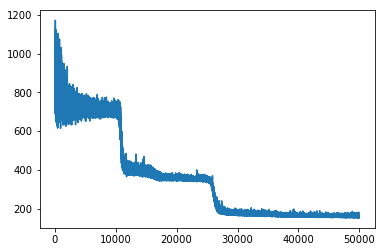

In [8]:
plt.plot(cost)

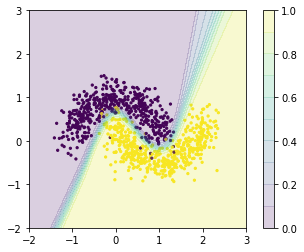

In [9]:
x_grid = np.mgrid[-2:3:100j, -2:3:100j]
x1, x2 = x_grid[0], x_grid[1]
x_grid = x_grid.reshape(2, -1).T

y_grid = np.mean([model(x_grid).reshape(100, 100) for _ in range(10)], axis=0)

plt.scatter(x_train[:, 0], x_train[:, 1], c=y_train, s=5)
plt.contourf(x1, x2, y_grid, np.linspace(0, 1, 11), alpha=0.2)
plt.colorbar()
plt.xlim(-2, 3)
plt.ylim(-2, 3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()